<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/2_PlantillaProyecto_EjRegresionGH/02S_S3_ValidacionCruzadaAnidada_covidCSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regresión Covid 19 - Validación cruzada vs Validación cruzada anidada

- Nota: la anidada busca cuantificar la variabilidad de los hiperparámetros del modelo.

## Validación cruzada

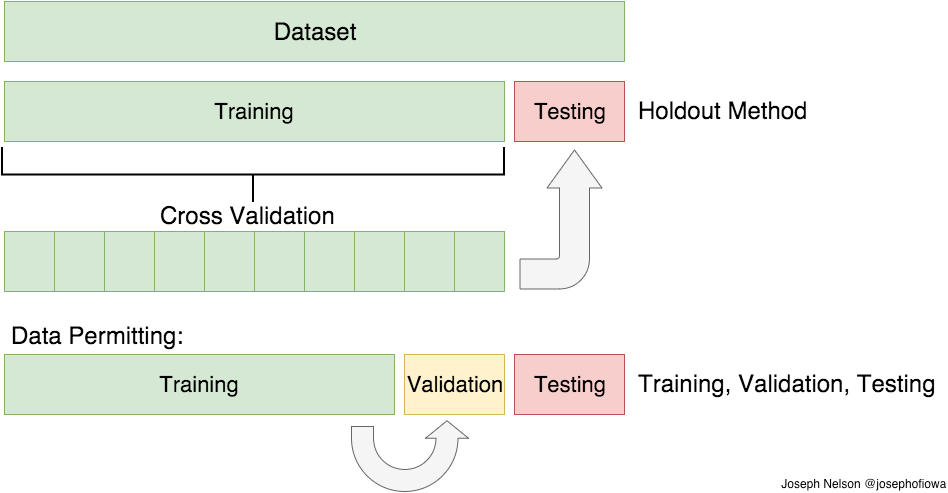


## Validación cruzada anidada

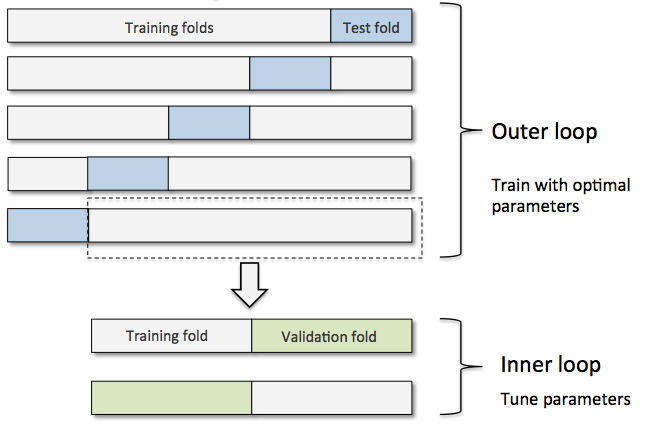

In [3]:
#descargar datos covid
!pip install wget
import wget
import pandas as pd
#datos covid19 - mundo
url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#datos Colombia
#url = "https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD"
wget.download(url, 'covid.csv')
Xd = pd.read_csv('covid.csv')
Xd

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,2/13/21,2/14/21,2/15/21,2/16/21,2/17/21,2/18/21,2/19/21,2/20/21,2/21/21,2/22/21,2/23/21,2/24/21,2/25/21,2/26/21,2/27/21,2/28/21,3/1/21,3/2/21,3/3/21,3/4/21,3/5/21,3/6/21,3/7/21,3/8/21,3/9/21,3/10/21,3/11/21,3/12/21,3/13/21,3/14/21,3/15/21,3/16/21,3/17/21,3/18/21,3/19/21,3/20/21,3/21/21,3/22/21,3/23/21,3/24/21
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,55473,55492,55514,55518,55540,55557,55575,55580,55604,55617,55646,55664,55680,55696,55707,55714,55733,55759,55770,55775,55827,55840,55847,55876,55876,55894,55917,55959,55959,55985,55985,55995,56016,56044,56069,56093,56103,56153,56177,56192
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91987,93075,93850,94651,95726,96838,97909,99062,100246,101285,102306,103327,104313,105229,106215,107167,107931,108823,109674,110521,111301,112078,112897,113580,114209,114840,115442,116123,116821,117474,118017,118492,118938,119528,120022,120541,121200,121544,121847,122295
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,110513,110711,110894,111069,111247,111418,111600,111764,111917,112094,112279,112461,112622,112805,112960,113092,113255,113430,113593,113761,113948,114104,114234,114382,114543,114681,114851,115008,115143,115265,115410,115540,115688,115842,115970,116066,116157,116255,116349,116438
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10463,10503,10538,10555,10583,10610,10645,10672,10699,10712,10739,10775,10799,10822,10849,10866,10889,10908,10948,10976,10998,11019,11042,11069,11089,11130,11130,11199,11228,11266,11289,11319,11360,11393,11431,11481,11517,11545,11591,11638
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20329,20366,20381,20389,20400,20452,20478,20499,20519,20548,20584,20640,20695,20759,20782,20807,20854,20882,20923,20981,21026,21055,21086,21108,21114,21161,21205,21265,21323,21380,21407,21446,21489,21558,21642,21696,21733,21757,21774,21836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,NaN,Vietnam,14.058324,108.277199,0,2,2,2,2,2,2,2,2,2,6,6,8,8,8,10,10,13,13,14,15,15,16,16,16,16,16,16,16,16,16,16,16,16,16,16,...,2195,2228,2269,2311,2329,2347,2362,2368,2383,2392,2403,2412,2421,2426,2432,2448,2448,2475,2482,2488,2494,2501,2512,2524,2526,2529,2533,2550,2553,2554,2557,2560,2567,2570,2571,2572,2572,2575,2575,2576
270,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,166800,167604,168444,169487,170527,171154,171717,172315,173635,174969,176377,177768,179293,180848,181909,183612,185336,187309,189326,191203,193029,194548,196812,198554,200382,202378,203669,205652,207436,209304,211602,213791,215984,218061,219912,221391,223638,225976,228044,230076
271,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2136,2145,2145,2148,2151,2154,2157,2157,2165,2176,2187,2221,2255,2267,2269,2285,2310,2342,2363,2375,2411,2444,2473,2545,2586,2627,2667,2729,2771,2836,2908,2969,3037,3126,3217,3278,3418,3516,3612,3703
272,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,68454,69437,70248,70823,71677,72467,73203,73894,74503,7

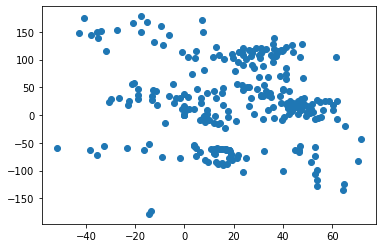

In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.scatter(Xd['Lat'],Xd['Long'])

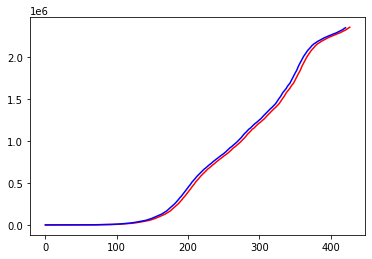

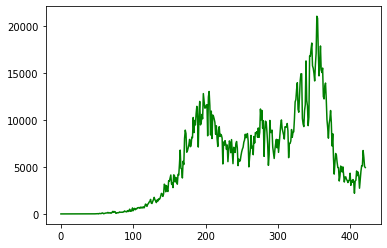

In [9]:
import numpy as np
import matplotlib.pyplot as plt

#funcion ventaneo
def covid_win(serie,w=5):
    pi =0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf].reshape(1,-1)
    pi += 1
    pf+= 1
    while pf+1 < serie.shape[0]:
      X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
      y = np.append(y,serie[pf].reshape(1,-1),axis=0)
      pi += 1
      pf+=1
    return X, y # X \in Real^{N x P = w}, y \in Real^N


ii = Xd[Xd.columns[1]] == 'Colombia'
#print(np.where(ii)[0][0])
#contagios  acumulados
serie = np.array(Xd.iloc[np.where(ii)[0][0],4:])
#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))
#serie_d = np.append(0,np.cumsum(np.diff(serie)))
w = 5
X,y = covid_win(serie,w=w)
X_d,y_d = covid_win(serie_d,w=w)
plt.plot(serie,'r')
plt.plot(y,'b')
plt.show()
plt.plot(y_d,'g')

#Xdata, ydata = X,y #acumulado contagiados
Xdata, ydata = X_d,y_d # contagiados x dia

# - Entrenamiento de regresor para covid 19 - Colombia
# - Validación cruzada y anidada utilizando búsqueda por grilla

$$y_{new}=reg((scaler(x_{new})))$$

fit: entrenamiento, ajuste, aprende los parámetros utilizando los hyperparámetros fijados.

Nota: la búsqueda por grilla facilita la estimación del rendimiento del sistema probando las combianciones de los hiperparámetros requeridos en el pipeline.

In [10]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from joblib import dump, load
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as msa



steps = [
         [('scaler', StandardScaler()), #estandarizar cada atributo en columna de xtrain centrada en 0 y var = 1
          ('reg',  KernelRidge(kernel = 'rbf'))], #regresor no lineal 
         [('scaler', StandardScaler()), #estandarizar cada atributo en columna de xtrain centrada en 0 y var = 1
          ('reg', KNeighborsRegressor())] #regresor por vecinos más cercanos
         ]        

#parametros a buscar por busqueda por grilla
parameters =[
             {'reg__gamma':[1e-3,1e-2,1e-1,1,10],
             'reg__alpha':[1e-3,1e-2,1e-1,1,10]
             },
             {
              'reg__n_neighbors': [1,3,5], #parametros n_neighbors debe ser siempre un int
             }
              ]

label_model = ['NorSC-KRRBF','NorSC-KNN']


# Nota: 

- En validación cruzada convencional (NO anidada) el outter loop no existe

- El gridsearch realiza la validación cruzada del inner loop

In [11]:
#valildacion cruzada anidada
Niter = 10 #numero particiones outter loop nested cross-validation
msev =np.zeros((Niter,len(steps)))#arreglo para guardar acierto
Nmod = len(steps) #numero de modelos a probar
best_estimators = Niter*[None]#mejor metodo por iteracion
###clave del funcionamiento
best_hyperpar = Niter*[None]#mejor metodo por iteracion 
#############################
for j in range(Niter): #outter loop
      #print('it %d/%d'%(j+1,Niter))
      #particiono datos outter loop
      X_train, X_test, y_train, y_test = train_test_split(Xdata,ydata,test_size=0.3) # xtrain 60, xtest 26
      list_est = [] #lista lazo interno para guardar mejor estimador por modelo para iteracion j
      list_hyper = [] #lista lazo interno para guardar mejores hyperparametros por modelo para iteracion j
      for r in range(Nmod): #recorro todos los posibles modelos a probar en iteracion j del outter loop
          grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r],cv=5,verbose=5,scoring='neg_mean_absolute_error',n_jobs=5) #cv inner loop
          #generar mejor modelo
          grid_search.fit(X_train,y_train) # se realiza inner loop dentro del gridsearch
          #estimar salida conjunto de test del outter loop
          y_pred = grid_search.best_estimator_.predict(X_test)
          #guardar mejor modelo
          list_est.append(grid_search.best_estimator_)
          list_hyper.append(grid_search.best_params_)
          #guardar acierto
          msev[j,r] = msa(y_test,y_pred)
          print('it %d/%d-Modelo %d/%d'%(j+1,Niter,r+1,len(steps)))
          print('best hyper', grid_search.best_params_)
          print('msa:',msev[j,r])
          
      best_estimators[j] = list_est #guardar mejores modelos 
      best_hyperpar[j] = list_hyper #mejores hyperparametros
          
          
      savedata = {
          'acc':msev,
          'best_models':best_estimators,
          'best_parameters':best_hyperpar,
            } 
      dump(savedata,'covid19_1.joblib')
      

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done  90 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    4.2s finished


it 1/10-Modelo 1/2
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.001}
msa: 791.9676140945498
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.2s finished


it 1/10-Modelo 2/2
best hyper {'reg__n_neighbors': 5}
msa: 935.968503937008
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.2s finished


it 2/10-Modelo 1/2
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.01}
msa: 630.4570853651352
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 2/10-Modelo 2/2
best hyper {'reg__n_neighbors': 5}
msa: 709.036220472441
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 3/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.001}
msa: 786.4955175927709
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 3/10-Modelo 2/2
best hyper {'reg__n_neighbors': 5}
msa: 788.7322834645669
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    1.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 4/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.001}
msa: 593.7609625382145
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Done   6 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 4/10-Modelo 2/2
best hyper {'reg__n_neighbors': 5}
msa: 662.3228346456692
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    1.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 5/10-Modelo 1/2
best hyper {'reg__alpha': 0.01, 'reg__gamma': 0.01}
msa: 704.2292402018122
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 5/10-Modelo 2/2
best hyper {'reg__n_neighbors': 5}
msa: 739.91968503937
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 6/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.001}
msa: 732.4407609613708
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 6/10-Modelo 2/2
best hyper {'reg__n_neighbors': 5}
msa: 806.4692913385827
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 7/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.001}
msa: 669.6156132495888
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 7/10-Modelo 2/2
best hyper {'reg__n_neighbors': 5}
msa: 792.8125984251969
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 8/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.001}
msa: 695.762667509091
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 8/10-Modelo 2/2
best hyper {'reg__n_neighbors': 5}
msa: 743.659842519685
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


it 9/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.001}
msa: 890.8914307118671
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 9/10-Modelo 2/2
best hyper {'reg__n_neighbors': 5}
msa: 883.9307086614173
Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


it 10/10-Modelo 1/2
best hyper {'reg__alpha': 0.001, 'reg__gamma': 0.001}
msa: 674.1710227801791
Fitting 5 folds for each of 3 candidates, totalling 15 fits
it 10/10-Modelo 2/2
best hyper {'reg__n_neighbors': 5}
msa: 839.447244094488


[Parallel(n_jobs=5)]: Done 125 out of 125 | elapsed:    0.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  15 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:    0.1s finished


$$w^* = (\Phi^\top \Phi + \lambda I)^{-1}\Phi^\top y $$

$$y_n = \phi_n w^*$$


$\lambda$: hyperparameter

$\Phi(x)=\mathcal{N}(x|\mu,\sigma^2)$

$\mu,\sigma$ hyperparameters

$w$: model's parameter

Por Niter de outter loop tengo valores de los hyperparameters, Ej:

$$\gamma = [0.01,0.1,10,1000,10000,0.01]$$

$$\gamma = [0.01,0.01,0.01,0.1,1,0.01]$$

$$\gamma^* = {\rm{mode}}(\gamma_i) = 0.01$$

Toma todos los datos los N, entreno sobre todo el conjunto con los hyperparametros encontrados utilizando validación cruzada anidada $\gamma^*$

$$w^* =f(X|\gamma^*)$$

$$ y_{new} = f(x_{new}|\gamma^*,w^*)$$

In [22]:
#Validacion cruzada inner loop ultima iteración ultimo modelo
print(grid_search.cv_results_)
print(grid_search.best_params_)

{'mean_fit_time': array([0.0018754 , 0.00196056, 0.00167494]), 'std_fit_time': array([0.00018215, 0.00033182, 0.00021616]), 'mean_score_time': array([0.00257678, 0.00317678, 0.0016789 ]), 'std_score_time': array([0.00187385, 0.00211494, 0.00044748]), 'param_reg__n_neighbors': masked_array(data=[1, 3, 5],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'reg__n_neighbors': 1}, {'reg__n_neighbors': 3}, {'reg__n_neighbors': 5}], 'split0_test_score': array([-1085.66101695,  -735.63841808,  -651.40338983]), 'split1_test_score': array([-821.30508475, -760.66666667, -673.78644068]), 'split2_test_score': array([-1372.61016949, -1116.5819209 , -1028.41355932]), 'split3_test_score': array([-1066.6440678 ,  -801.96045198,  -725.58305085]), 'split4_test_score': array([-970.47457627, -576.72881356, -582.84067797]), 'mean_test_score': array([-1063.33898305,  -798.31525424,  -732.40542373]), 'std_test_score': array([180.75512138, 176.49550204, 154

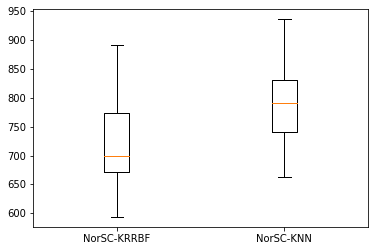

In [23]:
plt.boxplot(msev)
plt.xticks(ticks=np.arange(len(steps))+1,labels=label_model)
plt.show()

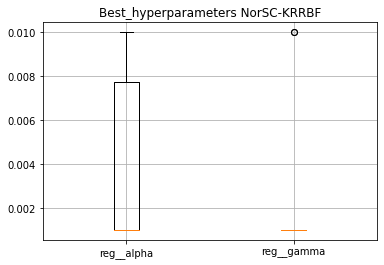

Modes=  [0.001 0.001]


In [24]:
from scipy.stats import mode
from datetime import date

r = 0 #hyperparameters model 
nh = len(best_hyperpar[0][r])
hyperpar_r = np.zeros((Niter,nh)) 
for i in range(Niter):
  for j in range(nh):
    hyperpar_r[i,j] = best_hyperpar[i][r].get(list(best_hyperpar[i][r].keys())[j])
    
    
#revisar numero entero para realizar casting
aa = list(best_hyperpar[0][r].keys())
c = -1
for i in range(len(aa)):
    if aa[i].find('n_neighbors') > -1:
      c = i

plt.boxplot(hyperpar_r)
plt.xticks(ticks=np.arange(nh)+1,labels=list(best_hyperpar[0][r].keys()))
plt.title('Best_hyperparameters '+label_model[r])
plt.grid()
plt.show()

mode_hyper = mode(hyperpar_r,axis=0)[0][0]
print("Modes= ", mode_hyper)




In [25]:
#entrenar con mejores hyperparametros
model_f = Pipeline(steps[r])
paramsf = parameters[r]
hyperl = list(parameters[r].keys())
nh = len(hyperl)
for j in range(nh):
  if j == c: 
    paramsf[hyperl[j]] = int(mode_hyper[j])
  else:
     paramsf[hyperl[j]] = mode_hyper[j] 

model_f.set_params(**paramsf)
model_f.fit(Xdata,ydata) #entrenar con todos los datos porque no tenemos suficientes > 10000 entrenar xtrain de lo contrario con todo el dataset

print('Predicción contagiados covid19 ',date.today(),'=',model_f.predict(serie[len(serie)-w:].reshape(1,-1))[0])

Predicción contagiados covid19  2021-03-25 = [0.]


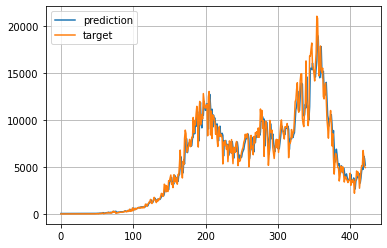

In [26]:
#curva predicción sobre modelo  final
plt.plot(model_f.predict(Xdata),label='prediction')
plt.plot(ydata,label='target')
plt.grid()
plt.legend()
plt.show()